# Imports and configs

In [66]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif, f_classif, RFE, VarianceThreshold, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import optuna
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.float_format', '{:.2f}'.format)

In [74]:
data = pd.read_csv(r'all_games_1819_2324_cleaned_new.csv')

In [4]:
data.shape

(37339, 170)

In [5]:
data.head()

,attendance,home_team_name,away_team_name,game_week,home_team_goal_count,away_team_goal_count,total_goal_count,total_goals_at_half_time,home_team_goal_count_half_time,away_team_goal_count_half_time,home_team_corner_count,away_team_corner_count,home_team_yellow_cards,home_team_red_cards,away_team_yellow_cards,away_team_red_cards,home_team_first_half_cards,home_team_second_half_cards,away_team_first_half_cards,away_team_second_half_cards,home_team_shots,away_team_shots,home_team_shots_on_target,away_team_shots_on_target,home_team_shots_off_target,away_team_shots_off_target,home_team_fouls,away_team_fouls,home_team_possession,away_team_possession,home_team_xg,away_team_xg,btts_percentage_pre_match,over_15_percentage_pre_match,over_25_percentage_pre_match,over_35_percentage_pre_match,over_45_percentage_pre_match,over_15_ht_fhg_percentage_pre_match,over_05_ht_fhg_percentage_pre_match,over_15_2hg_percentage_pre_match,over_05_2hg_percentage_pre_match,average_corners_per_match_pre_match,average_cards_per_match_pre_match,odds_ft_home_team_win,odds_ft_draw,odds_ft_away_team_win,odds_ft_over15,odds_ft_over25,odds_ft_over35,odds_ft_over45,odds_btts_yes,odds_btts_no,league,date,time,corners_total,yellow_cards_total,red_cards_total,cards_total,shots_total,shots_on_target_total,shots_off_target_total,fouls_total,result,season,home_team_cumulative_goals_scored_pre_game,away_team_cumulative_goals_scored_pre_game,home_team_cumulative_goals_conceded_pre_game,away_team_cumulative_goals_conceded_pre_game,home_team_average_goals_scored_per_game_pre_game,away_team_average_goals_scored_per_game_pre_game,home_team_average_goals_conceded_per_game_pre_game,away_team_average_goals_conceded_per_game_pre_game,home_team_average_first_half_goals_scored_pre_game,home_team_average_second_half_goals_scored_pre_game,away_team_average_first_half_goals_scored_pre_game,away_team_average_second_half_goals_scored_pre_game,home_team_average_first_half_goals_conceded_pre_game,home_team_average_second_half_goals_conceded_pre_game,away_team_average_first_half_goals_conceded_pre_game,away_team_average_second_half_goals_conceded_pre_game,home_team_average_first_half_goals_total_pre_game,home_team_average_second_half_goals_total_pre_game,away_team_average_first_half_goals_total_pre_game,away_team_average_second_half_goals_total_pre_game,home_team_average_corners_total_per_game_pre_game,away_team_average_corners_total_per_game_pre_game,home_team_average_corners_per_game_pre_game,away_team_average_corners_per_game_pre_game,home_team_average_yellow_cards_total_per_game_pre_game,away_team_average_yellow_cards_total_per_game_pre_game,home_team_average_yellow_cards_per_game_pre_game,away_team_average_yellow_cards_per_game_pre_game,home_team_cumulative_red_cards_pre_game,away_team_cumulative_red_cards_pre_game,home_team_average_red_cards_total_per_game_pre_game,away_team_average_red_cards_total_per_game_pre_game,home_team_average_red_cards_per_game_pre_game,away_team_average_red_cards_per_game_pre_game,home_team_average_shots_per_game_pre_game,home_team_average_shots_on_target_per_game_pre_game,away_team_average_shots_per_game_pre_game,away_team_average_shots_on_target_per_game_pre_game,home_team_average_fouls_per_game_pre_game,away_team_average_fouls_per_game_pre_game,home_team_average_fouls_total_per_game_pre_game,away_team_average_fouls_total_per_game_pre_game,home_team_average_possession_per_game_pre_game,away_team_average_possession_per_game_pre_game,home_team_average_xg_per_game_pre_game,away_team_average_xg_per_game_pre_game,home_team_games_without_goals_pre_game,away_team_games_without_goals_pre_game,home_team_cumulative_btts_pre_game,away_team_cumulative_btts_pre_game,home_team_cumulative_clean_sheets_pre_game,away_team_cumulative_clean_sheets_pre_game,home_team_cumulative_wins_pre_game,home_team_cumulative_draws_pre_game,home_team_cumulative_losses_pre_game,away_team_cumulative_wins_pre_game,away_team_cumulative_draws_pre_game,away_team_cumulative_losses_pre_game,home_te

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37339 entries, 0 to 37338
Columns: 170 entries, attendance to average_draw_odds_by_away_team_in_last_5_games
dtypes: float64(113), int64(51), object(6)
memory usage: 48.4+ MB


In [7]:
data.groupby(['league', 'season']).apply(lambda x: x['game_week'].isna().sum())

league              season
austria             18/19     0
                    19/20     0
                    20/21     0
                    21/22     0
                    22/23     0
                    23/24     0
belgium pro league  18/19     0
                    19/20     0
                    20/21     0
                    21/22     0
                    22/23     0
                    23/24     0
bundesliga          18/19     0
                    19/20     0
                    20/21     0
                    21/22     0
                    22/23     0
                    23/24     0
czech first league  18/19     0
                    19/20     0
                    20/21     0
                    21/22     0
                    22/23     0
                    23/24     0
denmark             18/19     0
                    19/20     0
                    20/21     0
                    21/22     0
                    22/23     0
                    23/24     0
ekstraklasa  

In [8]:
data.dtypes

attendance                                                  float64
home_team_name                                               object
away_team_name                                               object
game_week                                                   float64
home_team_goal_count                                          int64
away_team_goal_count                                          int64
total_goal_count                                              int64
total_goals_at_half_time                                      int64
home_team_goal_count_half_time                                int64
away_team_goal_count_half_time                                int64
home_team_corner_count                                        int64
away_team_corner_count                                        int64
home_team_yellow_cards                                        int64
home_team_red_cards                                           int64
away_team_yellow_cards                          

# Removing missing data

In [75]:
data['attendance'] = data['attendance'].replace({-1: 0})

In [76]:
cols_to_check_for_missing_values = [
    'home_team_goal_count',
    'away_team_goal_count',
    'total_goal_count',
    'total_goals_at_half_time',
    'home_team_goal_count_half_time',
    'away_team_goal_count_half_time',
    'home_team_corner_count',
    'away_team_corner_count',
    'home_team_yellow_cards',
    'home_team_red_cards',
    'away_team_yellow_cards',
    'away_team_red_cards',
    'home_team_first_half_cards',
    'home_team_second_half_cards',
    'away_team_first_half_cards',
    'away_team_second_half_cards',
    'home_team_shots',
    'away_team_shots',
    'home_team_shots_on_target',
    'away_team_shots_on_target',
    'home_team_shots_off_target',
    'away_team_shots_off_target',
    'home_team_fouls',
    'away_team_fouls',
    'home_team_possession',
    'away_team_possession'
]

In [11]:
rows_with_empties_in_stats = data[cols_to_check_for_missing_values].applymap(lambda x: x == -1).any(axis=1)

C:\Users\Łukasz\AppData\Local\Temp\ipykernel_25692\4074001773.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  rows_with_empties_in_stats = data[cols_to_check_for_missing_values].applymap(lambda x: x == -1).any(axis=1)


In [77]:
data = data[~rows_with_empties_in_stats]

In [78]:
data.shape

(36085, 170)

In [79]:
data['result'] = data['result'].astype('category')

In [17]:
def scale_data_arcsinh_std(df):
    num_features = df.select_dtypes(include='number').columns
    df[num_features] = np.arcsinh(df[num_features])
    df[num_features] = StandardScaler().fit_transform(df[num_features])
    return df

In [18]:
data = scale_data_arcsinh_std(data)

In [80]:
#conversion float64 and int64 to float32 and int32 to optimize computing
data[data.select_dtypes(include='float64').columns] = data[data.select_dtypes(include='float64').columns].astype('float32')
data[data.select_dtypes(include='int64').columns] = data[data.select_dtypes(include='int64').columns].astype('int32')

In [20]:
data.dtypes

attendance                                                   float32
home_team_name                                                object
away_team_name                                                object
game_week                                                    float32
home_team_goal_count                                         float32
away_team_goal_count                                         float32
total_goal_count                                             float32
total_goals_at_half_time                                     float32
home_team_goal_count_half_time                               float32
away_team_goal_count_half_time                               float32
home_team_corner_count                                       float32
away_team_corner_count                                       float32
home_team_yellow_cards                                       float32
home_team_red_cards                                          float32
away_team_yellow_cards            

# Feature selection

In [81]:
#dropping info leaking features and targets
X = data.drop([
    'home_team_name',
    'away_team_name',
    'home_team_goal_count',
    'away_team_goal_count',
    'total_goal_count',
    'total_goals_at_half_time',
    'home_team_goal_count_half_time',
    'away_team_goal_count_half_time',
    'date',
    'time',
    'result',
    'league',
    'season'
], axis=1)

In [82]:
y = data['result'].astype(int)

In [83]:
X = scale_data_arcsinh_std(X)

In [84]:
X

,attendance,game_week,home_team_corner_count,away_team_corner_count,home_team_yellow_cards,home_team_red_cards,away_team_yellow_cards,away_team_red_cards,home_team_first_half_cards,home_team_second_half_cards,away_team_first_half_cards,away_team_second_half_cards,home_team_shots,away_team_shots,home_team_shots_on_target,away_team_shots_on_target,home_team_shots_off_target,away_team_shots_off_target,home_team_fouls,away_team_fouls,home_team_possession,away_team_possession,home_team_xg,away_team_xg,btts_percentage_pre_match,over_15_percentage_pre_match,over_25_percentage_pre_match,over_35_percentage_pre_match,over_45_percentage_pre_match,over_15_ht_fhg_percentage_pre_match,over_05_ht_fhg_percentage_pre_match,over_15_2hg_percentage_pre_match,over_05_2hg_percentage_pre_match,average_corners_per_match_pre_match,average_cards_per_match_pre_match,odds_ft_home_team_win,odds_ft_draw,odds_ft_away_team_win,odds_ft_over15,odds_ft_over25,odds_ft_over35,odds_ft_over45,odds_btts_yes,odds_btts_no,corners_total,yellow_cards_total,red_cards_total,cards_total,shots_total,shots_on_target_total,shots_off_target_total,fouls_total,home_team_cumulative_goals_scored_pre_game,away_team_cumulative_goals_scored_pre_game,home_team_cumulative_goals_conceded_pre_game,away_team_cumulative_goals_conceded_pre_game,home_team_average_goals_scored_per_game_pre_game,away_team_average_goals_scored_per_game_pre_game,home_team_average_goals_conceded_per_game_pre_game,away_team_average_goals_conceded_per_game_pre_game,home_team_average_first_half_goals_scored_pre_game,home_team_average_second_half_goals_scored_pre_game,away_team_average_first_half_goals_scored_pre_game,away_team_average_second_half_goals_scored_pre_game,home_team_average_first_half_goals_conceded_pre_game,home_team_average_second_half_goals_conceded_pre_game,away_team_average_first_half_goals_conceded_pre_game,away_team_average_second_half_goals_conceded_pre_game,home_team_average_first_half_goals_total_pre_game,home_team_average_second_half_goals_total_pre_game,away_team_average_first_half_goals_total_pre_game,away_team_average_second_half_goals_total_pre_game,home_team_average_corners_total_per_game_pre_game,away_team_average_corners_total_per_game_pre_game,home_team_average_corners_per_game_pre_game,away_team_average_corners_per_game_pre_game,home_team_average_yellow_cards_total_per_game_pre_game,away_team_average_yellow_cards_total_per_game_pre_game,home_team_average_yellow_cards_per_game_pre_game,away_team_average_yellow_cards_per_game_pre_game,home_team_cumulative_red_cards_pre_game,away_team_cumulative_red_cards_pre_game,home_team_average_red_cards_total_per_game_pre_game,away_team_average_red_cards_total_per_game_pre_game,home_team_average_red_cards_per_game_pre_game,away_team_average_red_cards_per_game_pre_game,home_team_average_shots_per_game_pre_game,home_team_average_shots_on_target_per_game_pre_game,away_team_average_shots_per_game_pre_game,away_team_average_shots_on_target_per_game_pre_game,home_team_average_fouls_per_game_pre_game,away_team_average_fouls_per_game_pre_game,home_team_average_fouls_total_per_game_pre_game,away_team_average_fouls_total_per_game_pre_game,home_team_average_possession_per_game_pre_game,away_team_average_possession_per_game_pre_game,home_team_average_xg_per_game_pre_game,away_team_average_xg_per_game_pre_game,home_team_games_without_goals_pre_game,away_team_games_without_goals_pre_game,home_team_cumulative_btts_pre_game,away_team_cumulative_btts_pre_game,home_team_cumulative_clean_sheets_pre_game,away_team_cumulative_clean_sheets_pre_game,home_team_cumulative_wins_pre_game,home_team_cumulative_draws_pre_game,home_team_cumulative_losses_pre_game,away_team_cumulative_wins_pre_game,away_team_cumulative_draws_pre_game,away_team_cumulative_losses_pre_game,home_team_average_points_per_game_pre_game,away_team_average_points_per_game_pre_game,home_team_wins_in_last_5_games,home_team_draws_in_last_5_games,home_team_losses_in_last_5_games,away_team_wins_in_last_5_games,a

## Variance threshold

In [25]:
from sklearn.feature_selection import VarianceThreshold

# Przykład użycia z wartością progową wariancji równą 0.1
selector = VarianceThreshold(threshold=1)
X_new = selector.fit_transform(X)

# Wybrane cechy można sprawdzić tak:
selected_features = X.columns[selector.get_support(indices=True)]
print("Wybrane cechy:", selected_features)

Wybrane cechy: Index(['attendance', 'home_team_corner_count', 'away_team_corner_count',
       'home_team_first_half_cards', 'away_team_second_half_cards',
       'home_team_shots', 'away_team_shots', 'home_team_shots_on_target',
       'away_team_shots_on_target', 'home_team_shots_off_target',
       'away_team_shots_off_target', 'home_team_fouls', 'home_team_xg',
       'away_team_xg', 'over_45_percentage_pre_match',
       'average_corners_per_match_pre_match',
       'average_cards_per_match_pre_match', 'odds_ft_home_team_win',
       'odds_ft_draw', 'odds_ft_away_team_win', 'odds_ft_over45',
       'odds_btts_no', 'red_cards_total', 'shots_total', 'fouls_total',
       'away_team_average_goals_conceded_per_game_pre_game',
       'home_team_average_first_half_goals_conceded_pre_game',
       'home_team_average_corners_total_per_game_pre_game',
       'home_team_average_corners_per_game_pre_game',
       'away_team_average_corners_per_game_pre_game',
       'away_team_average_yellow

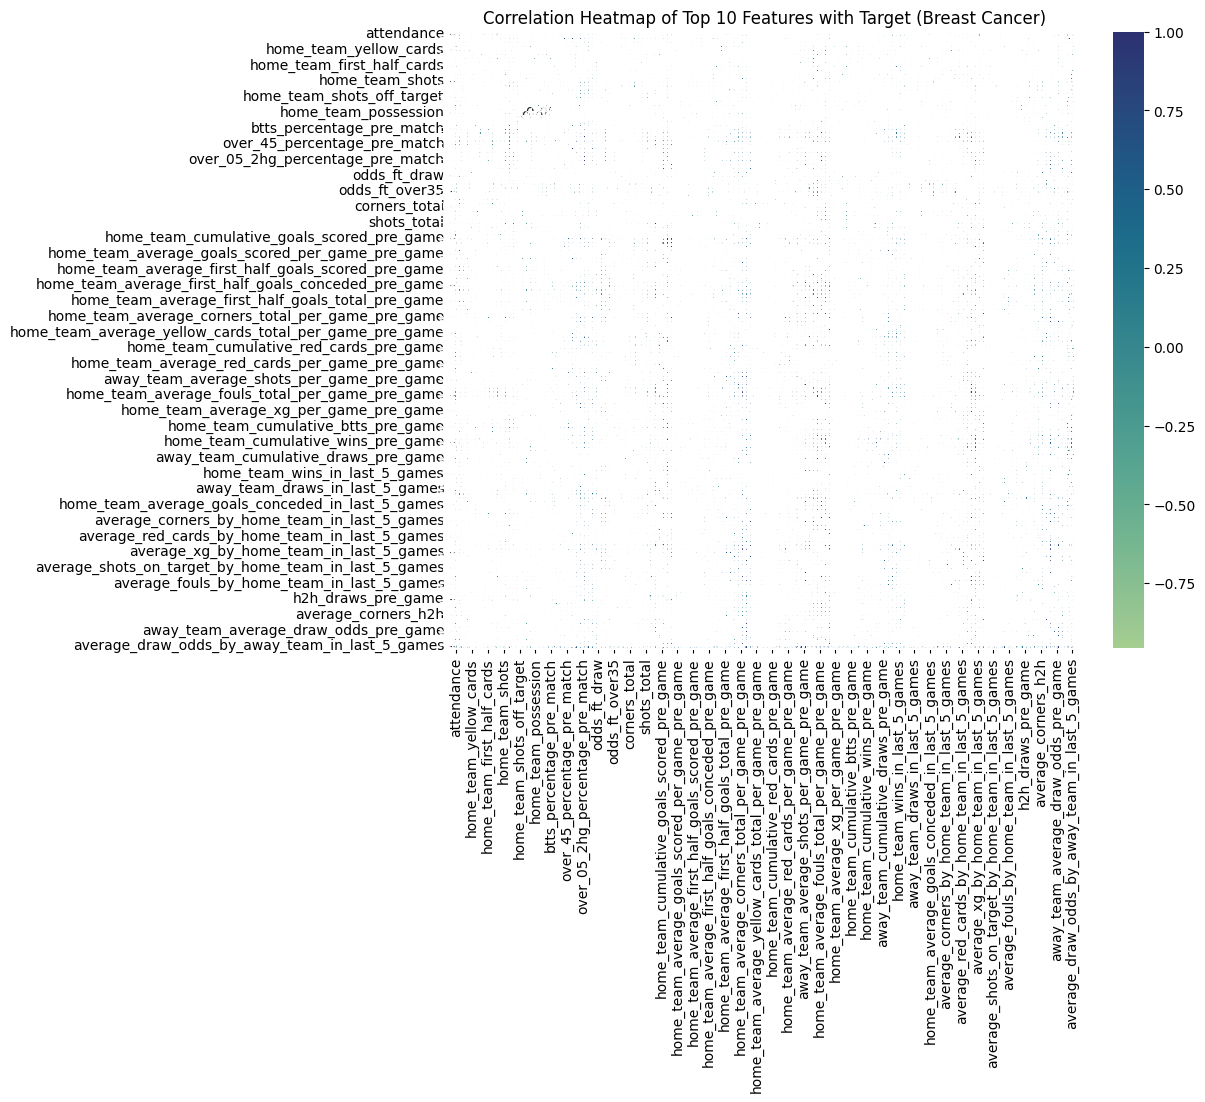

In [55]:
plt.figure(figsize=(10, 8))
sns.heatmap(X[num_features].corr(), annot=True, cmap='crest', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Top 10 Features with Target (Breast Cancer)')
plt.show()

In [26]:
correlation_values = X.apply(lambda feature: np.abs(np.corrcoef(feature, y)[0, 1]))

In [27]:
sorted_features = correlation_values.sort_values(ascending=False)

In [28]:
sorted_features

away_team_shots_on_target                                  0.22
odds_ft_home_team_win                                      0.19
away_team_xg                                               0.16
odds_ft_away_team_win                                      0.16
home_team_shots_on_target                                  0.14
away_team_shots                                            0.13
home_team_xg                                               0.10
shots_on_target_total                                      0.09
away_team_average_win_odds_pre_game                        0.09
home_team_shots                                            0.09
away_team_average_goals_scored_per_game_pre_game           0.09
away_team_average_points_per_game_pre_game                 0.09
away_team_average_first_half_goals_total_pre_game          0.09
away_team_average_first_half_goals_scored_pre_game         0.09
average_win_odds_by_away_team_in_last_5_games              0.09
away_team_average_goals_conceded_per_gam

In [29]:
# k = 10
selected_features = sorted_features.index[:30]

C:\Users\Łukasz\AppData\Local\Temp\ipykernel_25692\2678548279.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=selected_features, y=sorted_features[:30], palette='crest')


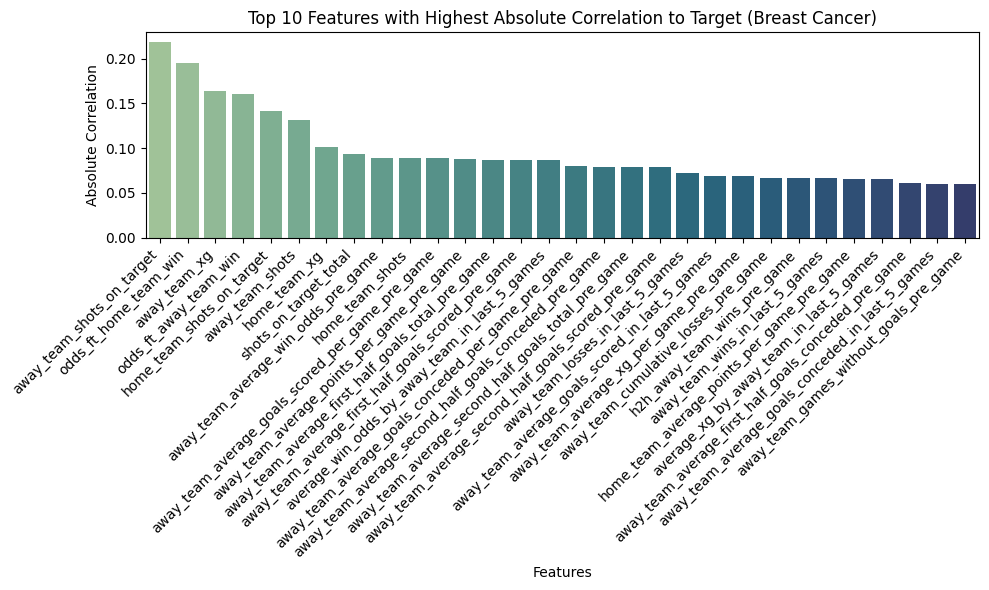

In [30]:
plt.figure(figsize=(10, 6))
sns.barplot(x=selected_features, y=sorted_features[:30], palette='crest')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Absolute Correlation')
plt.title('Top 10 Features with Highest Absolute Correlation to Target (Breast Cancer)')
plt.tight_layout()
plt.show()

In [31]:
variances = X.var()

In [33]:
len(selected_features)

63

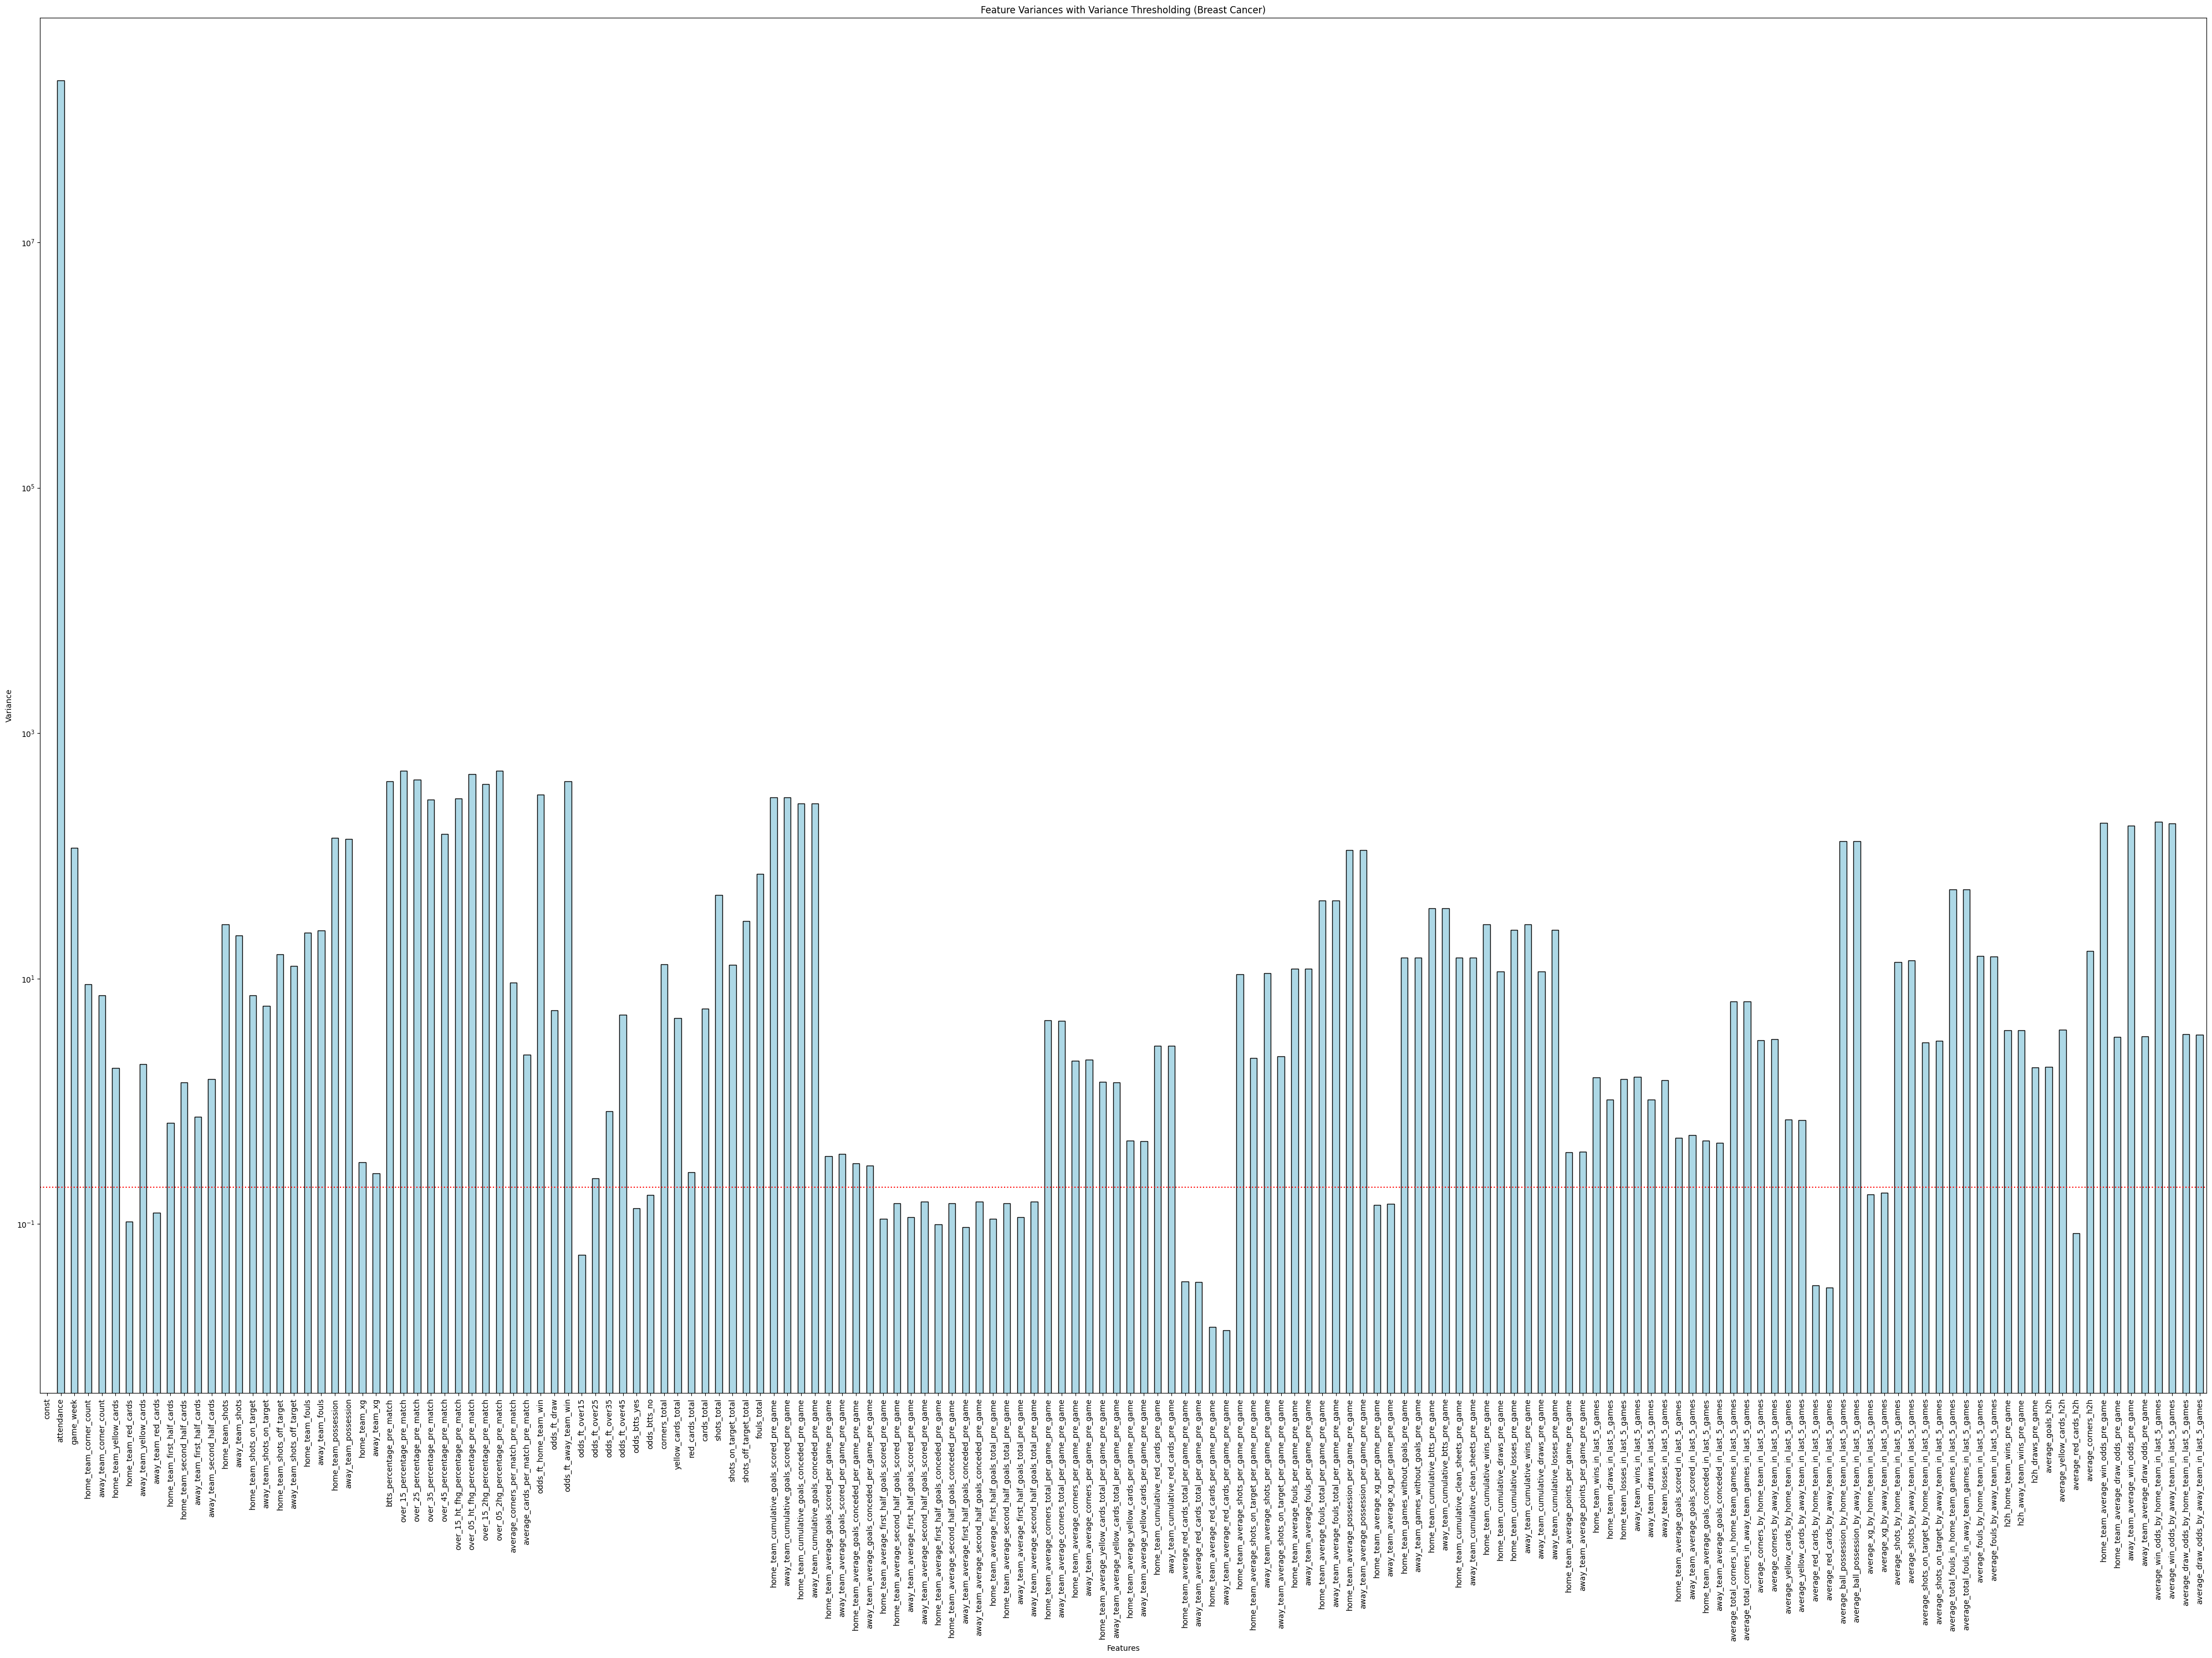

In [44]:
plt.figure(figsize=(40,30))
ax = pd.Series(variances, index=X.columns).plot(kind='bar', logy=True, color='lightblue', edgecolor='black')
ax.axhline(0.2, ls='dotted', c='red')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Variance')
plt.title('Feature Variances with Variance Thresholding (Breast Cancer)')
plt.tight_layout()
plt.show()

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)

In [37]:
num_features = X.select_dtypes('number').columns

In [38]:
X[num_features]

,attendance,game_week,home_team_corner_count,away_team_corner_count,home_team_yellow_cards,home_team_red_cards,away_team_yellow_cards,away_team_red_cards,home_team_first_half_cards,home_team_second_half_cards,away_team_first_half_cards,away_team_second_half_cards,home_team_shots,away_team_shots,home_team_shots_on_target,away_team_shots_on_target,home_team_shots_off_target,away_team_shots_off_target,home_team_fouls,away_team_fouls,home_team_possession,away_team_possession,home_team_xg,away_team_xg,btts_percentage_pre_match,over_15_percentage_pre_match,over_25_percentage_pre_match,over_35_percentage_pre_match,over_45_percentage_pre_match,over_15_ht_fhg_percentage_pre_match,over_05_ht_fhg_percentage_pre_match,over_15_2hg_percentage_pre_match,over_05_2hg_percentage_pre_match,average_corners_per_match_pre_match,average_cards_per_match_pre_match,odds_ft_home_team_win,odds_ft_draw,odds_ft_away_team_win,odds_ft_over15,odds_ft_over25,odds_ft_over35,odds_ft_over45,odds_btts_yes,odds_btts_no,corners_total,yellow_cards_total,red_cards_total,cards_total,shots_total,shots_on_target_total,shots_off_target_total,fouls_total,home_team_cumulative_goals_scored_pre_game,away_team_cumulative_goals_scored_pre_game,home_team_cumulative_goals_conceded_pre_game,away_team_cumulative_goals_conceded_pre_game,home_team_average_goals_scored_per_game_pre_game,away_team_average_goals_scored_per_game_pre_game,home_team_average_goals_conceded_per_game_pre_game,away_team_average_goals_conceded_per_game_pre_game,home_team_average_first_half_goals_scored_pre_game,home_team_average_second_half_goals_scored_pre_game,away_team_average_first_half_goals_scored_pre_game,away_team_average_second_half_goals_scored_pre_game,home_team_average_first_half_goals_conceded_pre_game,home_team_average_second_half_goals_conceded_pre_game,away_team_average_first_half_goals_conceded_pre_game,away_team_average_second_half_goals_conceded_pre_game,home_team_average_first_half_goals_total_pre_game,home_team_average_second_half_goals_total_pre_game,away_team_average_first_half_goals_total_pre_game,away_team_average_second_half_goals_total_pre_game,home_team_average_corners_total_per_game_pre_game,away_team_average_corners_total_per_game_pre_game,home_team_average_corners_per_game_pre_game,away_team_average_corners_per_game_pre_game,home_team_average_yellow_cards_total_per_game_pre_game,away_team_average_yellow_cards_total_per_game_pre_game,home_team_average_yellow_cards_per_game_pre_game,away_team_average_yellow_cards_per_game_pre_game,home_team_cumulative_red_cards_pre_game,away_team_cumulative_red_cards_pre_game,home_team_average_red_cards_total_per_game_pre_game,away_team_average_red_cards_total_per_game_pre_game,home_team_average_red_cards_per_game_pre_game,away_team_average_red_cards_per_game_pre_game,home_team_average_shots_per_game_pre_game,home_team_average_shots_on_target_per_game_pre_game,away_team_average_shots_per_game_pre_game,away_team_average_shots_on_target_per_game_pre_game,home_team_average_fouls_per_game_pre_game,away_team_average_fouls_per_game_pre_game,home_team_average_fouls_total_per_game_pre_game,away_team_average_fouls_total_per_game_pre_game,home_team_average_possession_per_game_pre_game,away_team_average_possession_per_game_pre_game,home_team_average_xg_per_game_pre_game,away_team_average_xg_per_game_pre_game,home_team_games_without_goals_pre_game,away_team_games_without_goals_pre_game,home_team_cumulative_btts_pre_game,away_team_cumulative_btts_pre_game,home_team_cumulative_clean_sheets_pre_game,away_team_cumulative_clean_sheets_pre_game,home_team_cumulative_wins_pre_game,home_team_cumulative_draws_pre_game,home_team_cumulative_losses_pre_game,away_team_cumulative_wins_pre_game,away_team_cumulative_draws_pre_game,away_team_cumulative_losses_pre_game,home_team_average_points_per_game_pre_game,away_team_average_points_per_game_pre_game,home_team_wins_in_last_5_games,home_team_draws_in_last_5_games,home_team_losses_in_last_5_games,away_team_wins_in_last_5_games,a

In [35]:
y.value_counts(normalize=True)

result
1    0.436059
2    0.305338
0    0.258604
Name: proportion, dtype: float64

# ANOVA

In [43]:
selector = SelectKBest(score_func=f_classif, k='all')

In [44]:
X_new = selector.fit_transform(X, y)

In [66]:
list(zip(X.columns, selector.scores_, selector.pvalues_))

In [67]:
pd.DataFrame(list(zip(X.columns, selector.scores_, selector.pvalues_)), columns=['feature', 'anova_f_score', 'p_value'])

,feature,anova_f_score,p_value
0,attendance,171.46,0.00
1,game_week,1.04,0.36
2,home_team_corner_count,19.75,0.00
3,away_team_corner_count,33.50,0.00
4,home_team_yellow_cards,154.20,0.00
5,home_team_red_cards,301.95,0.00
6,away_team_yellow_cards,29.11,0.00
7,away_team_red_cards,196.83,0.00
8,home_team_first_half_cards,117.77,0.00
9,home_team_second_half_cards,125.35,0.00


In [64]:
selector.scores_.mean()

212.75500998901916

In [46]:
selected_features_idx = selector.get_support(indices=True)
selected_feature_names = X.iloc[:, selected_features_idx].columns

In [47]:
selected_feature_names

Index(['attendance', 'game_week', 'home_team_corner_count',
       'away_team_corner_count', 'home_team_yellow_cards',
       'home_team_red_cards', 'away_team_yellow_cards', 'away_team_red_cards',
       'home_team_first_half_cards', 'home_team_second_half_cards',
       ...
       'average_red_cards_h2h', 'average_corners_h2h',
       'home_team_average_win_odds_pre_game',
       'home_team_average_draw_odds_pre_game',
       'away_team_average_win_odds_pre_game',
       'away_team_average_draw_odds_pre_game',
       'average_win_odds_by_home_team_in_last_5_games',
       'average_win_odds_by_away_team_in_last_5_games',
       'average_draw_odds_by_home_team_in_last_5_games',
       'average_draw_odds_by_away_team_in_last_5_games'],
      dtype='object', length=157)

In [86]:
num_features_to_select = 10 
selector = SelectKBest(score_func=f_classif, k=num_features_to_select)
X_new = selector.fit_transform(X, y)

In [90]:
list(selected_feature_indices)

[12, 13, 14, 15, 22, 23, 56, 57, 110, 111]

In [92]:
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = X.iloc[:, selected_feature_indices].columns

In [60]:
feature_names = X.columns

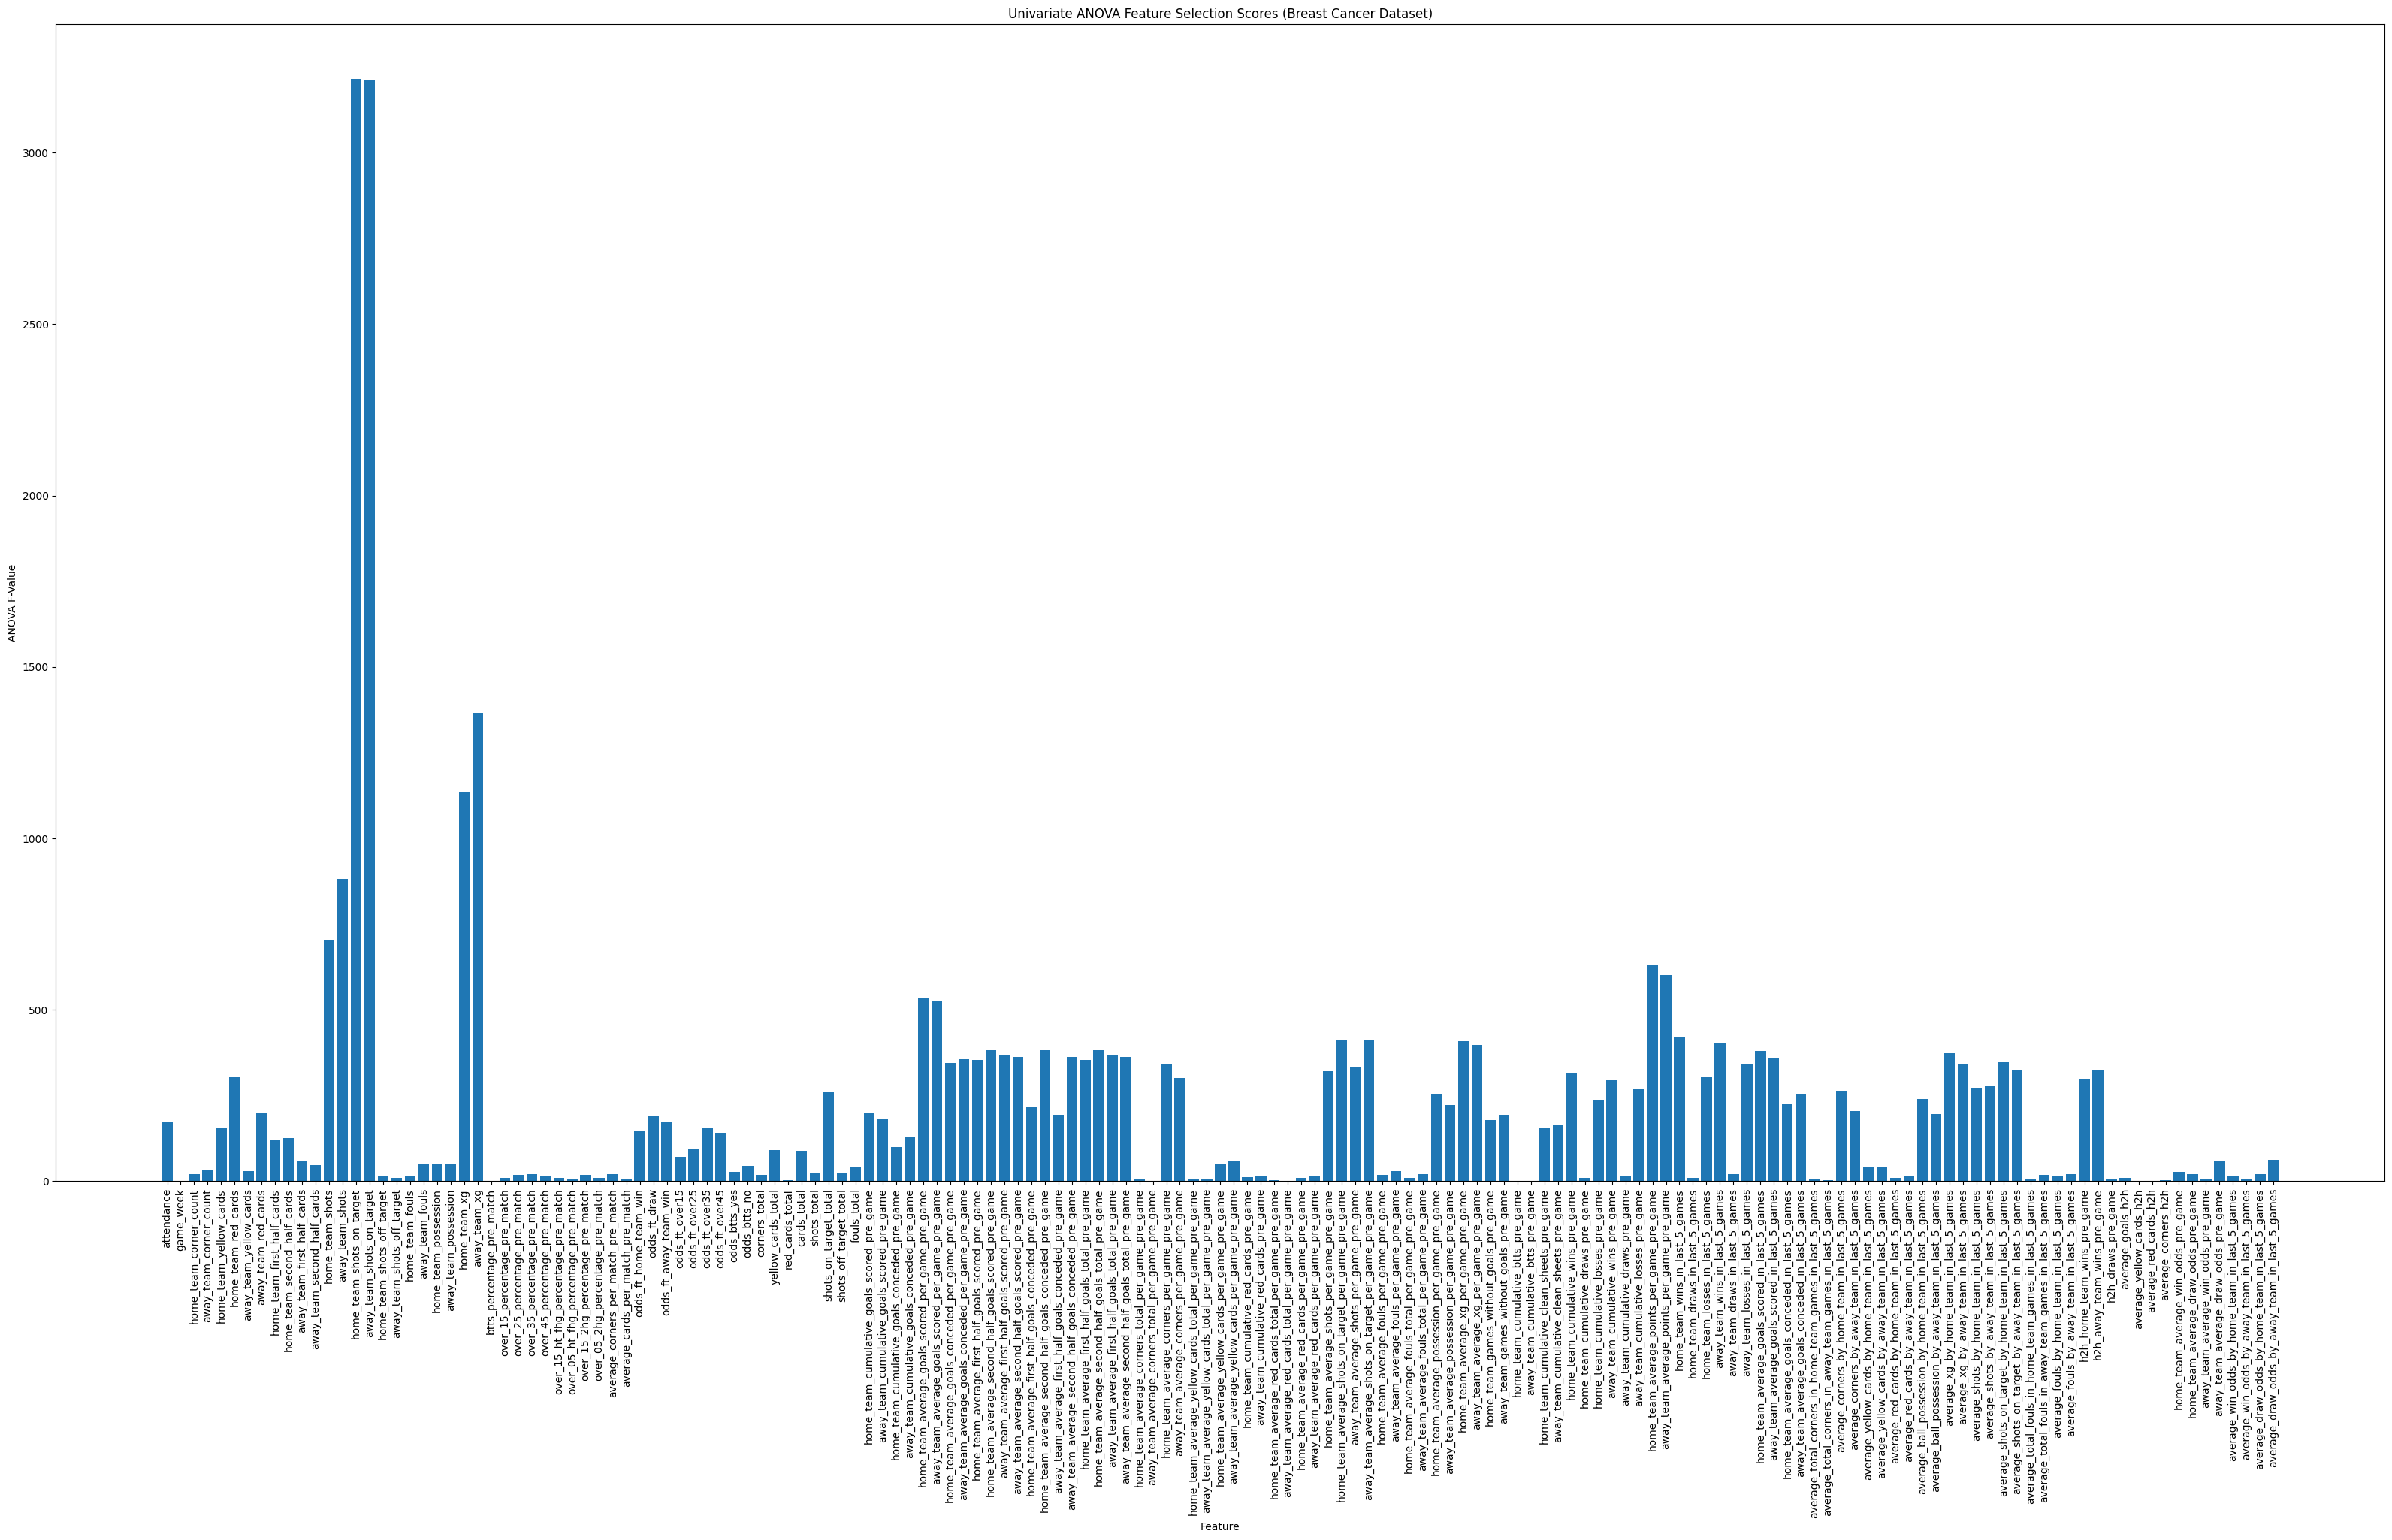

In [61]:
plt.figure(figsize=(40, 20))
plt.bar(range(len(feature_names)), selector.scores_, tick_label=feature_names)
plt.xlabel('Feature')
plt.ylabel('ANOVA F-Value')
plt.title('Univariate ANOVA Feature Selection Scores (Breast Cancer Dataset)')
plt.xticks(rotation=90)
plt.show()

# Variance Inflation Factor (VIF)

In [19]:
X = sm.add_constant(X)

In [20]:
vif_df = pd.DataFrame()

In [21]:
vif_df['feature'] = X.columns

In [23]:
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [24]:
vif_df

,feature,VIF
0,const,883.117883
1,attendance,1.224963
2,game_week,80.552438
3,home_team_corner_count,inf
4,away_team_corner_count,inf
5,home_team_yellow_cards,inf
6,home_team_red_cards,inf
7,away_team_yellow_cards,inf
8,away_team_red_cards,inf
9,home_team_first_half_cards,inf


In [25]:
vif_df[vif_df['VIF'] <= 10]

,feature,VIF
1,attendance,1.224963
25,btts_percentage_pre_match,4.106905
26,over_15_percentage_pre_match,9.843552
27,over_25_percentage_pre_match,5.992233
28,over_35_percentage_pre_match,4.016332
29,over_45_percentage_pre_match,2.377665
30,over_15_ht_fhg_percentage_pre_match,3.544260
31,over_05_ht_fhg_percentage_pre_match,4.687953
32,over_15_2hg_percentage_pre_match,5.095479
33,over_05_2hg_percentage_pre_match,5.329779


# Mutual information

In [53]:
features_scores = mutual_info_classif(X[num_features], y, random_state=42)

In [54]:
pd.DataFrame(dict(zip(num_features, features_scores)), index=['mutual_info_score']).T.sort_values(by='mutual_info_score', ascending=False)

,mutual_info_score
odds_ft_home_team_win,0.098469
home_team_shots_on_target,0.092151
odds_ft_away_team_win,0.089529
away_team_shots_on_target,0.081297
away_team_xg,0.035011
away_team_average_win_odds_pre_game,0.031711
home_team_average_win_odds_pre_game,0.031281
away_team_shots,0.031197
home_team_xg,0.029218
average_win_odds_by_home_team_in_last_5_games,0.026211


## Wrapper methods

### RFE

In [34]:
X

,attendance,game_week,home_team_corner_count,away_team_corner_count,home_team_yellow_cards,home_team_red_cards,away_team_yellow_cards,away_team_red_cards,home_team_first_half_cards,home_team_second_half_cards,away_team_first_half_cards,away_team_second_half_cards,home_team_shots,away_team_shots,home_team_shots_on_target,away_team_shots_on_target,home_team_shots_off_target,away_team_shots_off_target,home_team_fouls,away_team_fouls,home_team_possession,away_team_possession,home_team_xg,away_team_xg,btts_percentage_pre_match,over_15_percentage_pre_match,over_25_percentage_pre_match,over_35_percentage_pre_match,over_45_percentage_pre_match,over_15_ht_fhg_percentage_pre_match,over_05_ht_fhg_percentage_pre_match,over_15_2hg_percentage_pre_match,over_05_2hg_percentage_pre_match,average_corners_per_match_pre_match,average_cards_per_match_pre_match,odds_ft_home_team_win,odds_ft_draw,odds_ft_away_team_win,odds_ft_over15,odds_ft_over25,odds_ft_over35,odds_ft_over45,odds_btts_yes,odds_btts_no,corners_total,yellow_cards_total,red_cards_total,cards_total,shots_total,shots_on_target_total,shots_off_target_total,fouls_total,home_team_cumulative_goals_scored_pre_game,away_team_cumulative_goals_scored_pre_game,home_team_cumulative_goals_conceded_pre_game,away_team_cumulative_goals_conceded_pre_game,home_team_average_goals_scored_per_game_pre_game,away_team_average_goals_scored_per_game_pre_game,home_team_average_goals_conceded_per_game_pre_game,away_team_average_goals_conceded_per_game_pre_game,home_team_average_first_half_goals_scored_pre_game,home_team_average_second_half_goals_scored_pre_game,away_team_average_first_half_goals_scored_pre_game,away_team_average_second_half_goals_scored_pre_game,home_team_average_first_half_goals_conceded_pre_game,home_team_average_second_half_goals_conceded_pre_game,away_team_average_first_half_goals_conceded_pre_game,away_team_average_second_half_goals_conceded_pre_game,home_team_average_first_half_goals_total_pre_game,home_team_average_second_half_goals_total_pre_game,away_team_average_first_half_goals_total_pre_game,away_team_average_second_half_goals_total_pre_game,home_team_average_corners_total_per_game_pre_game,away_team_average_corners_total_per_game_pre_game,home_team_average_corners_per_game_pre_game,away_team_average_corners_per_game_pre_game,home_team_average_yellow_cards_total_per_game_pre_game,away_team_average_yellow_cards_total_per_game_pre_game,home_team_average_yellow_cards_per_game_pre_game,away_team_average_yellow_cards_per_game_pre_game,home_team_cumulative_red_cards_pre_game,away_team_cumulative_red_cards_pre_game,home_team_average_red_cards_total_per_game_pre_game,away_team_average_red_cards_total_per_game_pre_game,home_team_average_red_cards_per_game_pre_game,away_team_average_red_cards_per_game_pre_game,home_team_average_shots_per_game_pre_game,home_team_average_shots_on_target_per_game_pre_game,away_team_average_shots_per_game_pre_game,away_team_average_shots_on_target_per_game_pre_game,home_team_average_fouls_per_game_pre_game,away_team_average_fouls_per_game_pre_game,home_team_average_fouls_total_per_game_pre_game,away_team_average_fouls_total_per_game_pre_game,home_team_average_possession_per_game_pre_game,away_team_average_possession_per_game_pre_game,home_team_average_xg_per_game_pre_game,away_team_average_xg_per_game_pre_game,home_team_games_without_goals_pre_game,away_team_games_without_goals_pre_game,home_team_cumulative_btts_pre_game,away_team_cumulative_btts_pre_game,home_team_cumulative_clean_sheets_pre_game,away_team_cumulative_clean_sheets_pre_game,home_team_cumulative_wins_pre_game,home_team_cumulative_draws_pre_game,home_team_cumulative_losses_pre_game,away_team_cumulative_wins_pre_game,away_team_cumulative_draws_pre_game,away_team_cumulative_losses_pre_game,home_team_average_points_per_game_pre_game,away_team_average_points_per_game_pre_game,home_team_wins_in_last_5_games,home_team_draws_in_last_5_games,home_team_losses_in_last_5_games,away_team_wins_in_last_5_games,a

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
model = LogisticRegression(solver='liblinear', multi_class='ovr')

In [99]:
total_features = X_train.shape[1]
rfe = RFE(model, n_features_to_select=total_features)

# Fit the RFE to the training data
rfe.fit(X_train, y_train)

RFE(estimator=LogisticRegression(multi_class='ovr', solver='liblinear'),
    n_features_to_select=157)

In [100]:
ranking = rfe.ranking_

In [102]:
num_irrelevant_features_eliminated = np.arange(total_features - 1, -1, -1)

In [103]:
accuracy_list = []
for i in num_irrelevant_features_eliminated:
    rfe = RFE(model, n_features_to_select=(total_features - i))
    rfe.fit(X_train, y_train)
    y_pred = rfe.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)

plt.figure(figsize=(8, 6))
plt.plot(num_irrelevant_features_eliminated, accuracy_list, marker='o')
plt.xlabel("Number of Irrelevant Features Eliminated")
plt.ylabel("Accuracy")
plt.title("Model Performance as Irrelevant Features are Eliminated (RFE)")
plt.grid(True)
plt.show()

# Result prediction

## Random forest

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

### Base

In [56]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)

In [57]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, random_state=42)

In [58]:
y_pred = rf_model.predict(X_test)

In [59]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.03      0.07      1951
           1       0.53      0.90      0.67      3268
           2       0.57      0.47      0.52      2249

    accuracy                           0.54      7468
   macro avg       0.66      0.47      0.42      7468
weighted avg       0.63      0.54      0.46      7468



### Hyperparameters tuning with optuna

In [168]:
def objective(trial):
    # Number of trees in random forest
    n_estimators = trial.suggest_int(name="n_estimators", low=100, high=500, step=100)

    # Number of features to consider at every split
    max_features = trial.suggest_categorical(name="max_features", choices=['sqrt', 'log2', None]) 

    # Maximum number of levels in tree
    max_depth = trial.suggest_int(name="max_depth", low=10, high=110, step=20)

    # Minimum number of samples required to split a node
    min_samples_split = trial.suggest_int(name="min_samples_split", low=2, high=10, step=2)

    # Minimum number of samples required at each leaf node
    min_samples_leaf = trial.suggest_int(name="min_samples_leaf", low=1, high=4, step=1)
    
    params = {
        "n_estimators": n_estimators,
        "max_features": max_features,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf
    }
    model = RandomForestClassifier(random_state=42, **params)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    # cv_score = cross_val_score(model, X_train, y_train, n_jobs=4, cv=5)
    # mean_cv_accuracy = cv_score.mean()
    return acc

In [169]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

[I 2024-07-13 16:38:31,007] A new study created in memory with name: no-name-8088fcba-2a49-4459-9989-09039185b482
[W 2024-07-13 16:40:11,421] Trial 0 failed with parameters: {'n_estimators': 400, 'max_features': None, 'max_depth': 110, 'min_samples_split': 6, 'min_samples_leaf': 3} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Łukasz\AppData\Local\Temp\ipykernel_31148\3511437812.py", line 26, in objective
    model.fit(X_train, y_train)
  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\sklearn\ensemble\_forest.py

KeyboardInterrupt: 

## XGBoost

In [36]:
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3)

In [41]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

In [42]:
y_pred = xgb_model.predict(X_test)

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.25      0.31      1781
           1       0.69      0.81      0.74      3182
           2       0.64      0.68      0.66      2254

    accuracy                           0.63      7217
   macro avg       0.58      0.58      0.57      7217
weighted avg       0.60      0.63      0.61      7217



In [43]:
accuracy_score(y_test, y_pred)

0.6308715532769849

In [40]:
# Ustawienia dla XGBoost
params = {
    'max_depth': 3,  # głębokość drzew
    'eta': 0.1,      # współczynnik uczenia
    'objective': 'multi:softprob',  # funkcja straty dla klasyfikacji wieloklasowej
    'num_class': 3   # liczba klas wynikowych
}

# Przekształcenie danych do formatu DMatrix, który jest bardziej efektywny dla XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Trenowanie modelu
bst = xgb.train(params, dtrain, num_boost_round=100)

# Predykcja
y_pred_prob = bst.predict(dtest)
y_pred = np.argmax(y_pred_prob, axis=1)  # Wybieramy klasę z najwyższym prawdopodobieństwem

# Ocena modelu
accuracy = accuracy_score(y_test, y_pred)
print("Dokładność klasyfikacji XGBoost: {:.2f}%".format(accuracy * 100))

Dokładność klasyfikacji XGBoost: 63.64%


In [44]:
# Przekształcenie danych do formatu DMatrix, który jest bardziej efektywny dla XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [49]:
import xgboost as xgb
# from sklearn.metrics import mean_squared_error
import optuna

def objective(trial):
    #creating datasets in xgb interface
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    params = {
        "objective": "multi:softprob",
        # "objective": "multi:softmax",
        "num_class": "3",
        "n_estimators": 1000,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        # "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    # model = xgb.XGBClassifier(**params)
    # model.fit(X_train, y_train, verbose=False)
    
    bst = xgb.train(params, dtrain, num_boost_round=100)
    
    y_pred_prob = bst.predict(dtest)
    predictions = np.argmax(y_pred_prob, axis=1)
    
    # predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    return accuracy

In [50]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-07-22 23:48:36,415] A new study created in memory with name: no-name-dcd4c269-2102-4f06-a188-28ea88da6a95
[I 2024-07-22 23:48:39,206] Trial 0 finished with value: 0.624359152002217 and parameters: {'learning_rate': 0.022646945334416302, 'max_depth': 5, 'subsample': 0.563667456935539, 'colsample_bytree': 0.39157534062578037, 'min_child_weight': 14}. Best is trial 0 with value: 0.624359152002217.
[I 2024-07-22 23:48:41,954] Trial 1 finished with value: 0.5796037134543439 and parameters: {'learning_rate': 0.03288479013102527, 'max_depth': 5, 'subsample': 0.3782969548881446, 'colsample_bytree': 0.07973138540018962, 'min_child_weight': 6}. Best is trial 0 with value: 0.624359152002217.
[I 2024-07-22 23:48:47,136] Trial 2 finished with value: 0.5807122072883469 and parameters: {'learning_rate': 0.0021276165814568364, 'max_depth': 7, 'subsample': 0.9643086398926296, 'colsample_bytree': 0.17822023542507553, 'min_child_weight': 5}. Best is trial 0 with value: 0.624359152002217.
[I 2024-

In [67]:
xgb_optuna_best_params = study.best_params

In [75]:
xgb_optuna_best_params['objective'] = 'multi:softprob'

In [79]:
xgb_optuna_best_params['num_class'] = 3

In [80]:
xgb_optuna_best_params

{'learning_rate': 0.018854188545073352,
 'max_depth': 6,
 'subsample': 0.7473497986534416,
 'colsample_bytree': 0.42759609597862747,
 'min_child_weight': 12,
 'objective': 'multi:softprob',
 'num_class': 3}

In [81]:
#converting data to dmatrix format is more effective for xgboost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [82]:
#training xgboost on optimal params from optuna
bst = xgb.train(xgb_optuna_best_params, dtrain, num_boost_round=100)

In [83]:
y_pred_prob

array([0.975096  , 0.87281215, 0.949675  , ..., 0.92944056, 0.8956829 ,
       1.4719692 ], dtype=float32)

In [84]:
#prediction
y_pred_prob = bst.predict(dtest)
y_pred = np.argmax(y_pred_prob, axis=1)

In [86]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.10      0.17      1951
           1       0.63      0.87      0.73      3268
           2       0.61      0.70      0.65      2249

    accuracy                           0.62      7468
   macro avg       0.60      0.56      0.52      7468
weighted avg       0.60      0.62      0.56      7468



## LightGBM

In [51]:
import lightgbm as lgb

# Ustawienia
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'learning_rate': 0.1,
    'max_depth': 3,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5
}

# Trenowanie
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Model
model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=100)

# Predykcja
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Ocena
accuracy = accuracy_score(y_test, y_pred)
print("Dokładność klasyfikacji LightGBM: {:.2f}%".format(accuracy * 100))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21909
[LightGBM] [Info] Number of data points in the train set: 28868, number of used features: 157
[LightGBM] [Info] Start training from score -1.369531
[LightGBM] [Info] Start training from score -0.823812
[LightGBM] [Info] Start training from score -1.180848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

### Hyperparameter tuning

In [52]:
def objective(trial):
    param = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'num_class': 3,
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
        'max_depth': trial.suggest_int('max_depth', 1, 10)
    }

    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)

    model = lgb.train(param, train_data, valid_sets=[test_data])

    y_pred = model.predict(X_test)
    predictions = np.argmax(y_pred, axis=1)
    acc = accuracy_score(y_test, predictions)

    return acc


In [53]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-07-22 23:53:11,313] A new study created in memory with name: no-name-059a4cc1-7adf-4756-8405-5edb192e14cf
C:\Users\Łukasz\AppData\Local\Temp\ipykernel_25692\3038270508.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\Łukasz\AppData\Local\Temp\ipykernel_25692\3038270508.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\Łukasz\AppData\Local\Temp\ipykernel_25692\3038270508.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/

KeyboardInterrupt: 

In [99]:
lgbm_optuna_best_params = study.best_params

In [98]:
study.best_value

0.6373861810391002

## Catboost

In [45]:
# Inicjalizacja modelu
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=3,
    loss_function='MultiClass',  # dla klasyfikacji wieloklasowej
    verbose=True
)

# Trenowanie modelu
model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=10)

# Predykcja
y_pred = model.predict(X_test)

# Ocena modelu
accuracy = accuracy_score(y_test, y_pred)
print("Dokładność klasyfikacji CatBoost: {:.2f}%".format(accuracy * 100))

0:	learn: 1.0695420	test: 1.0693273	best: 1.0693273 (0)	total: 166ms	remaining: 2m 45s
1:	learn: 1.0447442	test: 1.0445342	best: 1.0445342 (1)	total: 175ms	remaining: 1m 27s
2:	learn: 1.0253517	test: 1.0248688	best: 1.0248688 (2)	total: 186ms	remaining: 1m 1s
3:	learn: 1.0085447	test: 1.0082299	best: 1.0082299 (3)	total: 195ms	remaining: 48.7s
4:	learn: 0.9953951	test: 0.9950106	best: 0.9950106 (4)	total: 204ms	remaining: 40.6s
5:	learn: 0.9844125	test: 0.9835919	best: 0.9835919 (5)	total: 217ms	remaining: 35.9s
6:	learn: 0.9733233	test: 0.9723330	best: 0.9723330 (6)	total: 226ms	remaining: 32.1s
7:	learn: 0.9646464	test: 0.9636294	best: 0.9636294 (7)	total: 236ms	remaining: 29.2s
8:	learn: 0.9574475	test: 0.9561854	best: 0.9561854 (8)	total: 245ms	remaining: 27s
9:	learn: 0.9503958	test: 0.9490091	best: 0.9490091 (9)	total: 255ms	remaining: 25.2s
10:	learn: 0.9450176	test: 0.9433279	best: 0.9433279 (10)	total: 263ms	remaining: 23.6s
11:	learn: 0.9389110	test: 0.9368161	best: 0.9368161

### Hyperparameter tuning

In [100]:
def objective(trial):
    param = {
        'loss_function': 'MultiClass',
        'iterations': trial.suggest_int('iterations', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 5, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_int('random_strength', 0, 100),
        'random_state': 42
    }

    model = CatBoostClassifier(**param)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False, early_stopping_rounds=100)

    y_pred = model.predict(X_test)
    predictions = np.argmax(y_pred, axis=1)
    
    acc = accuracy_score(y_test, predictions)
    
    return acc

In [101]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-07-14 16:24:04,305] A new study created in memory with name: no-name-d4b4ff32-4fa9-40c1-bc5b-e62c25399d2e
[I 2024-07-14 16:26:05,393] Trial 0 finished with value: 0.26124799143010174 and parameters: {'iterations': 327, 'learning_rate': 0.10869176717223722, 'depth': 9, 'l2_leaf_reg': 1, 'border_count': 239, 'bagging_temperature': 0.13453406117243294, 'random_strength': 10}. Best is trial 0 with value: 0.26124799143010174.
[W 2024-07-14 16:26:43,242] Trial 1 failed with parameters: {'iterations': 560, 'learning_rate': 0.02101335002607218, 'depth': 10, 'l2_leaf_reg': 10, 'border_count': 19, 'bagging_temperature': 0.980634100238481, 'random_strength': 39} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Łukasz\AppData\Local\Temp\ipykerne

KeyboardInterrupt: 

## Neural Network

In [123]:
np.array(y).reshape(-1, 1)

array([[1],
       [1],
       [2],
       ...,
       [1],
       [2],
       [2]], dtype=int64)

In [46]:
encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(np.array(y).reshape(-1, 1))

c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y_onehot, test_size=0.3, random_state=42)

In [49]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(X[selected_features].shape[1],)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(y_onehot.shape[1], activation='softmax')
])

In [50]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [51]:
model.fit(X_train, y_train, epochs=100, verbose=1)

Epoch 1/100


790/790 [==============================] - 2s 2ms/step - loss: 0.9734 - accuracy: 0.5334
Epoch 2/100
790/790 [==============================] - 1s 2ms/step - loss: 0.8648 - accuracy: 0.5975
Epoch 3/100
790/790 [==============================] - 1s 1ms/step - loss: 0.8467 - accuracy: 0.6086
Epoch 4/100
790/790 [==============================] - 1s 1ms/step - loss: 0.8364 - accuracy: 0.6131
Epoch 5/100
790/790 [==============================] - 1s 1ms/step - loss: 0.8284 - accuracy: 0.6191
Epoch 6/100
790/790 [==============================] - 1s 1ms/step - loss: 0.8216 - accuracy: 0.6218
Epoch 7/100
790/790 [==============================] - 1s 1ms/step - loss: 0.8161 - accuracy: 0.6238
Epoch 8/100
790/790 [==============================] - 1s 2ms/step - loss: 0.8119 - accuracy: 0.6288
Epoch 9/100
790/790 [==============================] - 1s 1ms/step - loss: 0.8094 - accuracy: 0.6288
Epoch 10/100
790/790 [==============================] - 1s 1ms/step - loss: 0.8066 - accu

In [52]:
_, accuracy = model.evaluate(X_test, y_test)

339/339 [==============================] - 1s 1ms/step - loss: 0.8110 - accuracy: 0.6253


In [139]:
X_train

,attendance,game_week,home_team_corner_count,away_team_corner_count,home_team_yellow_cards,home_team_red_cards,away_team_yellow_cards,away_team_red_cards,home_team_first_half_cards,home_team_second_half_cards,away_team_first_half_cards,away_team_second_half_cards,home_team_shots,away_team_shots,home_team_shots_on_target,away_team_shots_on_target,home_team_shots_off_target,away_team_shots_off_target,home_team_fouls,away_team_fouls,home_team_possession,away_team_possession,home_team_xg,away_team_xg,btts_percentage_pre_match,over_15_percentage_pre_match,over_25_percentage_pre_match,over_35_percentage_pre_match,over_45_percentage_pre_match,over_15_ht_fhg_percentage_pre_match,over_05_ht_fhg_percentage_pre_match,over_15_2hg_percentage_pre_match,over_05_2hg_percentage_pre_match,average_corners_per_match_pre_match,average_cards_per_match_pre_match,odds_ft_home_team_win,odds_ft_draw,odds_ft_away_team_win,odds_ft_over15,odds_ft_over25,odds_ft_over35,odds_ft_over45,odds_btts_yes,odds_btts_no,corners_total,yellow_cards_total,red_cards_total,cards_total,shots_total,shots_on_target_total,shots_off_target_total,fouls_total,home_team_cumulative_goals_scored_pre_game,away_team_cumulative_goals_scored_pre_game,home_team_cumulative_goals_conceded_pre_game,away_team_cumulative_goals_conceded_pre_game,home_team_average_goals_scored_per_game_pre_game,away_team_average_goals_scored_per_game_pre_game,home_team_average_goals_conceded_per_game_pre_game,away_team_average_goals_conceded_per_game_pre_game,home_team_average_first_half_goals_scored_pre_game,home_team_average_second_half_goals_scored_pre_game,away_team_average_first_half_goals_scored_pre_game,away_team_average_second_half_goals_scored_pre_game,home_team_average_first_half_goals_conceded_pre_game,home_team_average_second_half_goals_conceded_pre_game,away_team_average_first_half_goals_conceded_pre_game,away_team_average_second_half_goals_conceded_pre_game,home_team_average_first_half_goals_total_pre_game,home_team_average_second_half_goals_total_pre_game,away_team_average_first_half_goals_total_pre_game,away_team_average_second_half_goals_total_pre_game,home_team_average_corners_total_per_game_pre_game,away_team_average_corners_total_per_game_pre_game,home_team_average_corners_per_game_pre_game,away_team_average_corners_per_game_pre_game,home_team_average_yellow_cards_total_per_game_pre_game,away_team_average_yellow_cards_total_per_game_pre_game,home_team_average_yellow_cards_per_game_pre_game,away_team_average_yellow_cards_per_game_pre_game,home_team_cumulative_red_cards_pre_game,away_team_cumulative_red_cards_pre_game,home_team_average_red_cards_total_per_game_pre_game,away_team_average_red_cards_total_per_game_pre_game,home_team_average_red_cards_per_game_pre_game,away_team_average_red_cards_per_game_pre_game,home_team_average_shots_per_game_pre_game,home_team_average_shots_on_target_per_game_pre_game,away_team_average_shots_per_game_pre_game,away_team_average_shots_on_target_per_game_pre_game,home_team_average_fouls_per_game_pre_game,away_team_average_fouls_per_game_pre_game,home_team_average_fouls_total_per_game_pre_game,away_team_average_fouls_total_per_game_pre_game,home_team_average_possession_per_game_pre_game,away_team_average_possession_per_game_pre_game,home_team_average_xg_per_game_pre_game,away_team_average_xg_per_game_pre_game,home_team_games_without_goals_pre_game,away_team_games_without_goals_pre_game,home_team_cumulative_btts_pre_game,away_team_cumulative_btts_pre_game,home_team_cumulative_clean_sheets_pre_game,away_team_cumulative_clean_sheets_pre_game,home_team_cumulative_wins_pre_game,home_team_cumulative_draws_pre_game,home_team_cumulative_losses_pre_game,away_team_cumulative_wins_pre_game,away_team_cumulative_draws_pre_game,away_team_cumulative_losses_pre_game,home_team_average_points_per_game_pre_game,away_team_average_points_per_game_pre_game,home_team_wins_in_last_5_games,home_team_draws_in_last_5_games,home_team_losses_in_last_5_games,away_team_wins_in_last_5_games,a

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [147]:
import numpy as np
import pandas as pd

# Ustawienia początkowe
n_features = 149  # liczba cech
sequence_length = 10  # długość sekwencji

# Funkcja do przekształcania danych wejściowych w sekwencje
def create_sequences(X, y, sequence_length):
    n_samples = len(X) - sequence_length + 1
    X_seq = np.zeros((n_samples, sequence_length, X.shape[1]))
    y_seq = np.zeros(n_samples)

    for i in range(n_samples):
        X_seq[i] = X.iloc[i:i+sequence_length].values
        y_seq[i] = y.iloc[i+sequence_length-1]  # przypisujemy etykietę z ostatniego kroku w sekwencji

    return X_seq, y_seq

# Przetwarzanie X_train i y_train
X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)

# Przetwarzanie X_test i y_test (zakładam, że y_test również jest dostępny)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, sequence_length)

In [148]:
import tensorflow as tf

# Definiowanie modelu
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, input_shape=(sequence_length, n_features), return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Zakładam klasyfikację binarną; dostosuj w razie potrzeby
])

# Kompilacja modelu
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Dostosuj loss i activation w zależności od problemu

# Trenowanie modelu
history = model.fit(X_train_seq, y_train_seq, epochs=30, validation_data=(X_test_seq, y_test_seq), verbose=1)

Epoch 1/30
934/934 [==============================] - 16s 11ms/step - loss: -1.4234 - accuracy: 0.4354 - val_loss: -2.9558 - val_accuracy: 0.4373
Epoch 2/30
934/934 [==============================] - 9s 9ms/step - loss: -5.6096 - accuracy: 0.4357 - val_loss: -7.7222 - val_accuracy: 0.4373
Epoch 3/30
934/934 [==============================] - 9s 9ms/step - loss: -10.7457 - accuracy: 0.4357 - val_loss: -12.5743 - val_accuracy: 0.4373
Epoch 4/30
934/934 [==============================] - 9s 10ms/step - loss: -16.2755 - accuracy: 0.4357 - val_loss: -17.2603 - val_accuracy: 0.4373
Epoch 5/30
235/934 [======>.......................] - ETA: 8s - loss: -20.2336 - accuracy: 0.4266

KeyboardInterrupt: 

# Score prediction (home_team_goal_count, away_team_goal_count)

In [54]:
data.shape

(36085, 170)

In [55]:
y_scores = data[['home_team_goal_count', 'away_team_goal_count']]

In [56]:
X_train_scores, X_test_scores, y_train_scores, y_test_scores = train_test_split(X, y_scores, test_size=0.2, random_state=42)

In [59]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

KeyboardInterrupt: 

In [62]:
from sklearn.linear_model import LinearRegression

In [63]:
model = LinearRegression()

In [64]:
model.fit(X_train_scores, y_train_scores)

LinearRegression()

In [68]:
# Predykcja na danych testowych
y_pred_scores = model.predict(X_test_scores)

# Obliczenie błędów
mse = mean_squared_error(y_test_scores, y_pred_scores)
r2 = r2_score(y_test_scores, y_pred_scores)

print(f"MSE: {mse}")
print(f"R^2: {r2}")

MSE: 0.6292352080345154
R^2: 0.36682088919381783


In [85]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# Przygotowanie danych
# X = df.drop(['home_team_goal_count', 'away_team_goal_count'], axis=1)
y_home = data['home_team_goal_count']
y_away = data['away_team_goal_count']

# Trenowanie modelu dla drużyny gospodarzy
X_train, X_test, y_home_train, y_home_test = train_test_split(X, y_home, test_size=0.2, random_state=42)
model_home = sm.GLM(y_home_train, X_train, family=sm.families.Poisson()).fit()

# Trenowanie modelu dla drużyny gości
X_train, X_test, y_away_train, y_away_test = train_test_split(X, y_away, test_size=0.2, random_state=42)
model_away = sm.GLM(y_away_train, X_train, family=sm.families.Poisson()).fit()

# Przewidywanie
y_home_pred = model_home.predict(X_test)
y_away_pred = model_away.predict(X_test)

# Możesz dalej dostosować sposób wykorzystania tych przewidywań, np. generując macierz prawdopodobieństw dla różnych wyników meczów

In [86]:
y_home_pred

27849   0.63
10964   0.82
29162   2.31
30468   1.62
1270    1.74
        ... 
261     1.66
21195   1.41
25195   1.58
19022   0.52
21474   2.03
Length: 7217, dtype: float64

In [71]:
y_away_pred

27849   2.00
10964   1.52
29162   1.01
30468   1.25
1270    1.41
        ... 
261     1.71
21195   1.45
25195   0.62
19022   3.23
21474   0.59
Length: 7217, dtype: float64

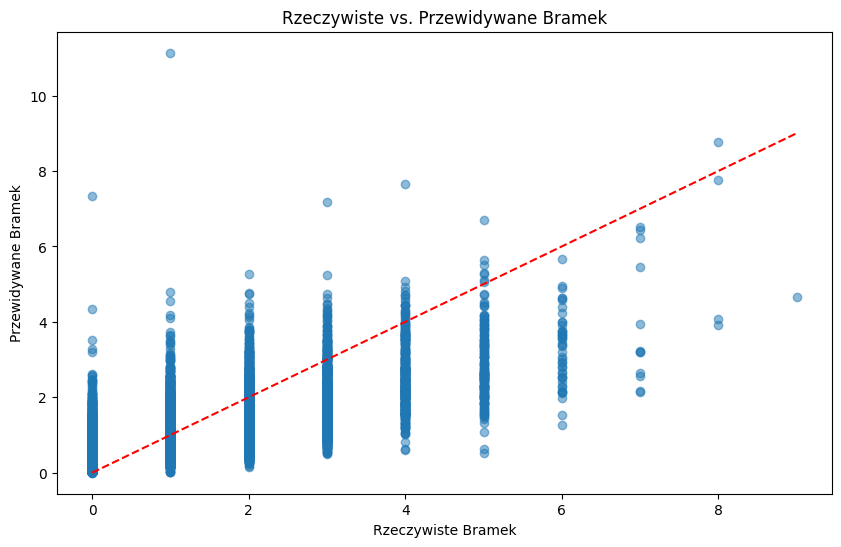

In [87]:
import matplotlib.pyplot as plt

# Wykres rzeczywistych vs. przewidywanych wartości
plt.figure(figsize=(10, 6))
plt.scatter(y_home_test, y_home_pred, alpha=0.5)
plt.plot([min(y_home_test), max(y_home_test)], [min(y_home_test), max(y_home_test)], 'r--')  # Linia idealnego dopasowania
plt.title('Rzeczywiste vs. Przewidywane Bramek')
plt.xlabel('Rzeczywiste Bramek')
plt.ylabel('Przewidywane Bramek')
plt.show()